In [2]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from collections import Counter
import time, random, re, pprint, string, copy
import scipy.misc
from itertools import islice, chain
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
print(sys.version_info)

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


# Load in Data and Take a Look

In [3]:
%timeit
#Load Data: 
train_x = np.load('tinyX.npy') 
train_y = np.load('tinyY.npy') 

In [4]:
train_y

array([ 0,  0,  0, ..., 39, 39, 39], dtype=uint8)

In [5]:
len(train_x[0][0][0])

64

In [6]:
train_x.shape

(26344, 3, 64, 64)

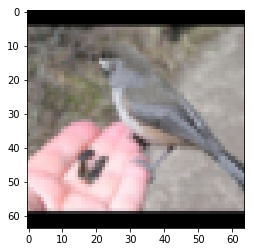

In [9]:
plt.imshow(train_x[0].transpose(2,1,0)) # put RGB channels last
plt.show()

In [10]:
#Counts of examples per category
pd.DataFrame(train_y)[0].value_counts().head()

0    8000
1    4000
2    2080
3    1040
4     800
Name: 0, dtype: int64

In [11]:
# Reshape the array into two-dimensions
x2 = np.reshape(train_x, (26344,-1))
x2.shape

(26344, 12288)

# Neural Network

Architechture in the Neural Network: 

Our training data is of dim: $n \times p$ (n training examples, p parameters)

We will start with a simple Neural-Net with 2 layers: 1 hidden layer, and one output later

Each of the M nodes in the first hidden layer has an p-vector of weights,and a single constant. This means that the hidden layer  is represented by a $m \times 1$ vector of constants $b$, and an $m \times p$ matrix of weights $W$. An arbitrary hidden layer $i$ is represented by an $m \times 1$ vector of constants $b_i$ and a $m \times q$ matrix of weights $W_i$, where $q$ is the number of nodes in the prior layer $i-1$. 

In each node, we use the sigmoid function to transoform the input $a_{i-1}$ into the output $a_i$ by: $a_i = \sigma(B_i + a_{i-1} W_i)$

As we deal with classification, we predict using the final output of the last layer using the softmax function: $P_k(a) = \frac{e^{ak}}{\sum_1^K e^{Ti}}$. Where $K$ is the toal number of classes

The error for the output given the set of weights is calculated as the cross-entropy deviance. $$\sum_{i=1}^N \sum_{k=1}^K \ y_{ik} \ ln( f_k(x_i))$$

Where $f_k(x_i)$ is the output probability (from softmax) of class $k$ for training example $x_i$ 


To train the network, we use back propogation, which is analogous to gradient descent on the weights. 







In [12]:
pd.DataFrame(train_y)[0].value_counts().shape[0]

40

In [264]:
def accuracy(y, truey): 
    return sum(y == truey) / len(y)

def oos_accuracy(X, truey, weights): 
    probs = prop_forward(X,weights[0], weights[1], weights[2], weights[3])
    classes = np.argmax(probs, axis = 1)
    return sum(classes == truey) / len(truey)

In [260]:
#sigmoid function 
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

#Forward Propogation
def prop_forward(X, w01,W1,w02,W2):
    a1 = sigmoid(w01.T + X.dot(W1)) #Output from layer 1
    a2 = w02.T + a1.dot(W2) #Output from Layer 2 before Softmax
    predicted_probs = np.exp(a2) / sum(np.exp(a2)) #probabilities
    #predicted = max(predicted_probs)
    return  predicted_probs

def forward_back(X,y, alpha,w01, W1,w02,W2):
    #performs one iteration of updating
    
    #Forward Propogation
    a1 = sigmoid(w01.T + X.dot(W1)) #Output from layer 1
    a2 = w02.T + a1.dot(W2) #Output from Layer 2 before Softmax
    probs_out = np.exp(a2) / sum(np.exp(a2)) #probabilities
    class_out = np.argmax(probs_out, axis = 1)
    
    
    #Backwards propogation
    dy = probs_out # dy = y - t
    dy[range(len(dy)), y] -= 1
    
    dw02 = dy
    dW2 = (a1.T).dot(dy)
    ds = a1 * (1 - a1) #derivative of the sigmoid function
    dW1 = X.T.dot(dy.dot(W2.T)*ds)
    dw01 = np.sum(dy.dot(W2.T), axis = 0)
    
#     print("dy = " + str(dy))
#     print("a1 = " + str(a1[0:20]))
#     print("a2 = " + str(a2[0:20]))
#     print("probs_out = " + str(probs_out))
#     print("dw01 = " + str(dw01[0:20]))
#     print("dw02 = " + str(dw02[0:20]))
#     print("dW1 = " + str(dW1[0:20]))
#     print("dW2 = " + str(dW2[0:20]))
   
    #Update all weights in direction of gradient
    w02 -= alpha * w02
    W2 -= alpha * dW2
    w01 -= alpha * dw01
    W1 -= alpha * dW1
    
    return [w01, W1, w02, W2]

In [268]:
#Training the model: 
def train(X, y, n_nodes, alpha, maxn): 
    
    #Set Constants 
    n_exs = X.shape[0]
    n_dims = X.shape[1]
    n_classes = pd.DataFrame(y)[0].value_counts().shape[0]
    
    #Initialize Weights Randomely
    w01 = np.zeros(n_nodes)
    W1 = np.random.randn(n_dims, n_nodes)
    w02 = np.zeros(n_classes)
    W2 = np.random.randn(n_nodes, n_classes)
    
    for i in range(0,maxn):
        #Gradient descent to train the weights- forward and backwards propogation
        w01, W1, w02, W2 = forward_back(X, y, alpha, w01,W1, w02,W2)

        if (i % 100 == 0):
            #check the progress
            probs_out = prop_forward(X, w01, W1, w02, W2)
            loss = sum(-np.log(probs_out[range(len(probs_out)), y]))
            print(" i = " + str(i) + ", error = " + str(loss))
        
        
    probs_out = prop_forward(X, w01,W1, w02, W2)
    class_out = np.argmax(probs_out, axis = 1)
    
    return probs_out, class_out, [w01, W1, w02, W2]

In [289]:
n_train = 1000
index = random.sample(range(len(x2)), n_train)

In [295]:
%%time
weights = []
probs, classes, weights = train(x2[index], train_y[index], 10, 1e-6,100)

 i = 0, error = 7285.55079383
CPU times: user 31.7 s, sys: 4.18 s, total: 35.9 s
Wall time: 9.28 s


In [296]:
print("In Sample Accuracy = " + str(accuracy(classes,train_y[index])))
oos_index = list(set(range(len(x2))) - set(index)) #index for out of sample
print("Out of Sample Accuracy = " + str(oos_accuracy(x2, train_y, weights)))

In Sample Accuracy = 0.005
Out of Sample Accuracy = 0.0123747342848
